<a href="https://colab.research.google.com/github/harshilj0310/Data-Science-Notebooks/blob/main/POS_tagging_final_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
from nltk.corpus import brown
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
nltk.download('brown')
nltk.download('universal_tagset')

tagged_sentences = brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Ashok\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Ashok\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

tokenized_sentences = []

for sentence in tagged_sentences:
    tokenized_sentence = []
    for word, tag in sentence:
        tokens = word_tokenize(word)
        tokenized_sentence.extend([(token, tag) for token in tokens])

    tokenized_sentences.append(tokenized_sentence)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ashok\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [ ]:
def calculate_transition_probs(tagged_sentences):
    tag_counts = defaultdict(lambda: 0)
    transition_counts = defaultdict(lambda: defaultdict(lambda: 0))

    for sentence in tagged_sentences:
        prev_tag = '<START>'
        for word, tag in sentence:
            tag_counts[prev_tag] += 1
            transition_counts[prev_tag][tag] += 1
            prev_tag = tag
        tag_counts[prev_tag] += 1
        transition_counts[prev_tag]['<END>'] += 1

    transition_probs = defaultdict(lambda: defaultdict(lambda: 0))

    for prev_tag, tag_dict in transition_counts.items():
        for tag, count in tag_dict.items():
            transition_probs[prev_tag][tag] = count / tag_counts[prev_tag]

    return transition_probs

def calculate_emission_probs(tagged_sentences):
    tag_counts = defaultdict(lambda: 0)
    emission_counts = defaultdict(lambda: defaultdict(lambda: 0))

    for sentence in tagged_sentences:
        for word, tag in sentence:
            tag_counts[tag] += 1
            emission_counts[tag][word.lower()] += 1

    emission_probs = defaultdict(lambda: defaultdict(lambda: 0))

    for tag, word_dict in emission_counts.items():
        for word, count in word_dict.items():
            emission_probs[tag][word] = count / tag_counts[tag]

    return emission_probs


In [ ]:
def viterbi_algorithm(words, transition_probs, emission_probs, tag_set):
    viterbi = []
    backpointer = []
    first_viterbi = {}
    first_backpointer = {}
    for tag in tag_set:
        if words[0].lower() in emission_probs[tag]:
            first_viterbi[tag] = transition_probs['<START>'][tag] * emission_probs[tag][words[0].lower()]
        else:
            first_viterbi[tag] = transition_probs['<START>'][tag] * 0.00001
        first_backpointer[tag] = '<START>'

    viterbi.append(first_viterbi)
    backpointer.append(first_backpointer)

    for i in range(1, len(words)):
        this_viterbi = {}
        this_backpointer = {}
        prev_viterbi = viterbi[-1]

        for tag in tag_set:
            best_previous = max(prev_viterbi.keys(), key=lambda prev_tag: prev_viterbi[prev_tag] * transition_probs[prev_tag][tag])
            this_viterbi[tag] = prev_viterbi[best_previous] * transition_probs[best_previous][tag]
            if words[i].lower() in emission_probs[tag]:
                this_viterbi[tag] *= emission_probs[tag][words[i].lower()]
            else:
                this_viterbi[tag] *= 0.00001
            this_backpointer[tag] = best_previous

        viterbi.append(this_viterbi)
        backpointer.append(this_backpointer)

    best_last_tag = max(viterbi[-1].keys(), key=lambda tag: viterbi[-1][tag] * transition_probs[tag]['<END>'])
    best_path = [best_last_tag]

    for backpointer_dict in reversed(backpointer[1:]):
        best_last_tag = backpointer_dict[best_last_tag]
        best_path.insert(0, best_last_tag)

    return best_path

Average Accuracy: 0.9270625900222941


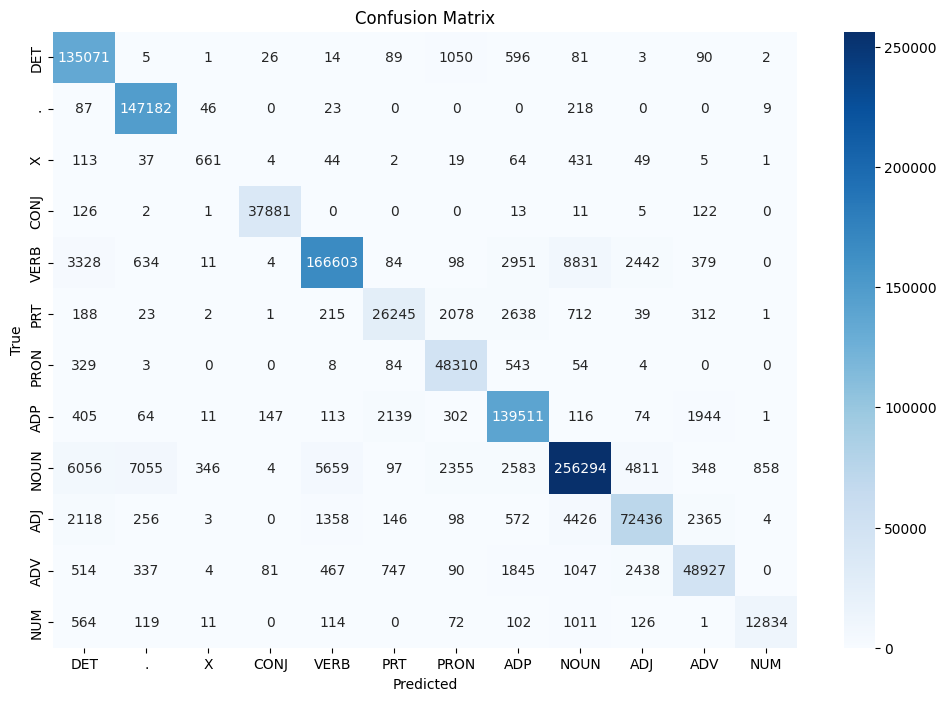

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
confusion_matrices = []
tag_set = set(tag for sentence in tokenized_sentences for word, tag in sentence)

for train_index, test_index in kf.split(tokenized_sentences):
    train_data = [tokenized_sentences[i] for i in train_index]
    test_data = [tokenized_sentences[i] for i in test_index]

    transition_probs = calculate_transition_probs(train_data)
    emission_probs = calculate_emission_probs(train_data)

    y_true = []
    y_pred = []

    for sentence in test_data:
        words = [word for word, tag in sentence]
        true_tags = [tag for word, tag in sentence]
        predicted_tags = viterbi_algorithm(words, transition_probs, emission_probs, tag_set)

        y_true.extend(true_tags)
        y_pred.extend(predicted_tags)

    accuracy = accuracy_score(y_true, y_pred)
    fold_accuracies.append(accuracy)
    cm = confusion_matrix(y_true, y_pred, labels=list(tag_set))
    confusion_matrices.append(cm)

average_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy: {average_accuracy}")

confusion_matrices = [np.array(cm) for cm in confusion_matrices]
overall_cm = np.sum(confusion_matrices, axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(overall_cm, annot=True, fmt='d', xticklabels=list(tag_set), yticklabels=list(tag_set), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, labels=list(tag_set))

print("Per POS Performance:")
for tag, p, r, f1 in zip(list(tag_set), precision, recall, f1_score):
    print(f"{tag}: P={p:.2f}, R={r:.2f}, F1={f1:.2f}")

overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
f0_5 = (1 + 0.5**2) * (overall_precision * overall_recall) / (0.5**2 * overall_precision + overall_recall)
f2 = (1 + 2**2) * (overall_precision * overall_recall) / (2**2 * overall_precision + overall_recall)

print("Overall Performance:")
print(f"Precision: {overall_precision:.2f}")
print(f"Recall: {overall_recall:.2f}")
print(f"F1-score: {overall_f1:.2f}")
print(f"F0.5-score: {f0_5:.2f}")
print(f"F2-score: {f2:.2f}")

Per POS Performance:
DET: P=0.91, R=0.99, F1=0.94
.: P=0.95, R=1.00, F1=0.97
X: P=0.63, R=0.46, F1=0.53
CONJ: P=0.99, R=0.99, F1=0.99
VERB: P=0.95, R=0.90, F1=0.93
PRT: P=0.88, R=0.81, F1=0.84
PRON: P=0.89, R=0.98, F1=0.93
ADP: P=0.92, R=0.96, F1=0.94
NOUN: P=0.94, R=0.90, F1=0.92
ADJ: P=0.88, R=0.87, F1=0.87
ADV: P=0.90, R=0.86, F1=0.88
NUM: P=0.93, R=0.87, F1=0.90
Overall Performance:
Precision: 0.90
Recall: 0.88
F1-score: 0.89
F0.5-score: 0.89
F2-score: 0.88


In [ ]:
errors = [(true, pred) for true, pred in zip(y_true, y_pred) if true != pred]
error_analysis = Counter(errors)
print("Top 10 Common Errors:")
for error, count in error_analysis.most_common(10):
    print(f"{error}: {count}")

Top 10 Common Errors:
('VERB', 'NOUN'): 1847
('NOUN', '.'): 1337
('NOUN', 'DET'): 1249
('NOUN', 'VERB'): 1123
('NOUN', 'ADJ'): 1004
('ADJ', 'NOUN'): 912
('VERB', 'DET'): 690
('VERB', 'ADP'): 620
('PRT', 'ADP'): 588
('NOUN', 'ADP'): 569


In [ ]:
# def tag_sentence(sentence, transition_probs, emission_probs, tag_set):
#     words = sentence.split()
#     predicted_tags = viterbi_algorithm(words, transition_probs, emission_probs, tag_set)
#     return list(zip(words, predicted_tags))

# demo_sentence = ""
# print(tag_sentence(demo_sentencThe quick brown fox jumps over the lazy doge, transition_probs, emission_probs, tag_set))

In [ ]:
# import gradio as gr

# def tag_sentence(sentence):
#     words = sentence.split()
#     predicted_tags = viterbi_algorithm(words, transition_probs, emission_probs, tag_set)
#     return list(zip(words, predicted_tags))

# demo = gr.Interface(
#     fn=tag_sentence,
#     inputs=gr.Textbox(lines=2, placeholder="Enter a sentence..."),
#     outputs=gr.JSON(label="POS Tagged Output"),
#     title="POS Tagger",
#     description="Enter a sentence to tag it with parts of speech."
# )

# demo.launch(share=True)


In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold
def word2features(sentence, i):
    word = sentence[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sentence[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sentence)-1:
        word1 = sentence[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sentence):
    return [word2features(sentence, i) for i in range(len(sentence))]

def sent2labels(sentence):
    return [tag for word, tag in sentence]

# Train the CRF model using KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for train_index, test_index in kf.split(tokenized_sentences):
    train_sents = [tokenized_sentences[i] for i in train_index]
    test_sents = [tokenized_sentences[i] for i in test_index]

    X_train = [sent2features(s) for s in train_sents]
    y_train = [sent2labels(s) for s in train_sents]
    X_test = [sent2features(s) for s in test_sents]
    y_test = [sent2labels(s) for s in test_sents]

    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )
    crf.fit(X_train, y_train)

    y_pred = crf.predict(X_test)
    accuracy = metrics.flat_accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    labels = list(crf.classes_)
    sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
    print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3))

average_crf_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"CRF Average Accuracy: {average_crf_accuracy:.4f}")


              precision    recall  f1-score   support

           .      0.998     0.999     0.999     29520
           X      0.819     0.400     0.538       340
         ADJ      0.945     0.929     0.937     16789
         ADP      0.979     0.984     0.981     28779
         ADV      0.951     0.938     0.945     11332
        VERB      0.978     0.979     0.978     37267
         DET      0.994     0.995     0.994     27475
        CONJ      0.995     0.996     0.996      7531
        NOUN      0.972     0.981     0.977     56975
        PRON      0.991     0.988     0.990      9934
         PRT      0.949     0.942     0.946      6373
         NUM      0.986     0.965     0.975      2938

    accuracy                          0.978    235253
   macro avg      0.963     0.925     0.938    235253
weighted avg      0.978     0.978     0.978    235253

              precision    recall  f1-score   support

           .      0.999     0.999     0.999     29348
           X      0.805 

Per POS Performance:
DET: P=0.99, R=1.00, F1=0.99
.: P=1.00, R=1.00, F1=1.00
X: P=0.82, R=0.52, F1=0.64
CONJ: P=0.99, R=1.00, F1=1.00
VERB: P=0.98, R=0.98, F1=0.98
PRT: P=0.95, R=0.95, F1=0.95
PRON: P=0.99, R=0.99, F1=0.99
ADP: P=0.98, R=0.98, F1=0.98
NOUN: P=0.97, R=0.98, F1=0.98
ADJ: P=0.94, R=0.93, F1=0.93
ADV: P=0.95, R=0.93, F1=0.94
NUM: P=0.98, R=0.97, F1=0.98
CRF Average Accuracy: 0.9777


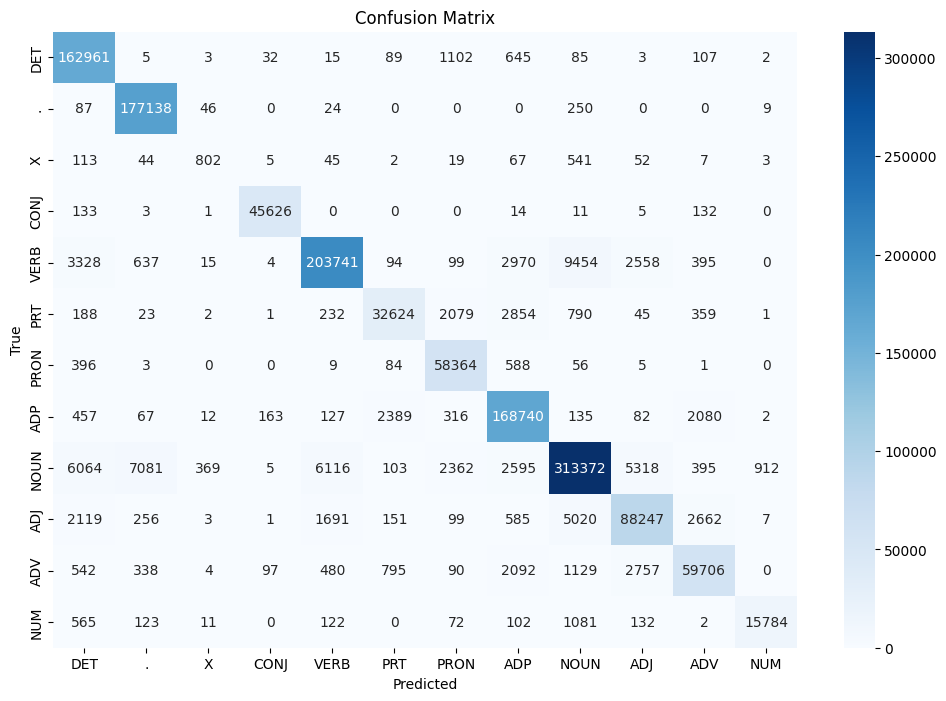

Overall Performance:
Precision: 0.96
Recall: 0.94
F1-score: 0.95
F0.5-score: 0.96
F2-score: 0.94
Top 10 Common Errors:
('VERB', 'NOUN'): 623
('ADJ', 'NOUN'): 594
('NOUN', 'ADJ'): 507
('NOUN', 'VERB'): 457
('ADJ', 'VERB'): 333
('ADV', 'ADJ'): 319
('ADJ', 'ADV'): 297
('ADP', 'PRT'): 250
('ADV', 'ADP'): 247
('PRT', 'ADP'): 216


In [ ]:
y_true_flat = [item for sublist in y_test for item in sublist]
y_pred_flat = [item for sublist in y_pred for item in sublist]

accuracy = accuracy_score(y_true_flat, y_pred_flat)
fold_accuracies.append(accuracy)

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=list(tag_set))
confusion_matrices.append(cm)

        # Precision, Recall, F1 Scores
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_flat, y_pred_flat, labels=list(tag_set))
print("Per POS Performance:")
for tag, p, r, f1 in zip(list(tag_set), precision, recall, f1_score):
    print(f"{tag}: P={p:.2f}, R={r:.2f}, F1={f1:.2f}")

# Average Accuracy across folds
average_accuracy = np.mean(fold_accuracies)
print(f"CRF Average Accuracy: {average_accuracy:.4f}")

# Overall Confusion Matrix
confusion_matrices = [np.array(cm) for cm in confusion_matrices]
overall_cm = np.sum(confusion_matrices, axis=0)

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(overall_cm, annot=True, fmt='d', xticklabels=list(tag_set), yticklabels=list(tag_set), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Overall Precision, Recall, F1, F0.5, F2 Scores
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(y_true_flat, y_pred_flat, average='macro')
f0_5 = (1 + 0.5**2) * (overall_precision * overall_recall) / (0.5**2 * overall_precision + overall_recall)
f2 = (1 + 2**2) * (overall_precision * overall_recall) / (2**2 * overall_precision + overall_recall)

print("Overall Performance:")
print(f"Precision: {overall_precision:.2f}")
print(f"Recall: {overall_recall:.2f}")
print(f"F1-score: {overall_f1:.2f}")
print(f"F0.5-score: {f0_5:.2f}")
print(f"F2-score: {f2:.2f}")

# Error Analysis
errors = [(true, pred) for true, pred in zip(y_true_flat, y_pred_flat) if true != pred]
error_analysis = Counter(errors)
print("Top 10 Common Errors:")
for error, count in error_analysis.most_common(10):
    print(f"{error}: {count}")

In [ ]:
import gradio as gr

def tag_sentence(sentence):
    words = sentence.split()
    predicted_tags = viterbi_algorithm(words, transition_probs, emission_probs, tag_set)
    return list(zip(words, predicted_tags))

demo = gr.Interface(
    fn=tag_sentence,
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence..."),
    outputs=gr.JSON(label="POS Tagged Output"),
    title="POS Tagger using HMM",
    description="Enter a sentence to tag it with parts of speech."
)

demo.launch(share=True)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://dd7391052ba14c9190.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
def pos_tagger(input_text):
    words = word_tokenize(input_text)
    sentence = [(word, None) for word in words]  # No tags available for prediction

    features = sent2features(sentence)
    predicted_tags = crf.predict([features])[0]

    tagged_sentence = list(zip(words, predicted_tags))
    return tagged_sentence

In [ ]:
print(pos_tagger("I am a nice guy working on an innovative idea!"))

[('I', 'PRON'), ('am', 'VERB'), ('a', 'DET'), ('nice', 'ADJ'), ('guy', 'NOUN'), ('working', 'VERB'), ('on', 'ADP'), ('an', 'DET'), ('innovative', 'ADJ'), ('idea', 'NOUN'), ('!', '.')]


In [ ]:
gr_interface = gr.Interface(
    fn=pos_tagger,
    inputs=gr.Textbox(lines=2, placeholder="Enter a sentence..."),
    outputs="json",
    title="POS Tagging with CRF",
    description="Enter a sentence to predict Part of Speech (POS) tags using a CRF model."
)

# Launch Gradio interface
gr_interface.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.
